In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.cluster.hierarchy as hac

import pandas

import glob
import struct
from collections import Counter

# Расшифровка протокола беспроводного устройства

# на примере датчика движения PA-92R

Как помочь нам разобрать протокол?

Вот пример как это делается в простом случае.

Есть устройство на чипе HS1527 и к нему даже нашелся datasheet: http://sc-tech.cn/en/hs1527.pdf

Есть Wiren Board c rfsniffer. Первое что мы делаем, записываем дамп. 

`{some path}/wb-homa-rfsniffer -W`

Когда запись произойдет, останавливаем программу и начинаем изучать данные, сохраненные в `.rcf` файле.

(Извиняюсь за смесь русского и английского в комментариях)


In [58]:
# takes filename
# open file, read binary data
# returns numpy.array of impulses (positive integer)
# and pauses (negative integer)
def file_to_data(filename):
    pic = open(filename, "rb")
    data = []
    while True:
        buf = pic.read(4)
        if not buf or len(buf) != 4:
            break
        sign = 1 if buf[3] == 1 else -1
        buf = bytes(buf[:3] + bytes([0]))
        data.append(sign * struct.unpack('i', buf)[0])
    return np.array(data)

# takes files' mask
# returns numpy.array of data
def files_to_data(mask):
    # откуда брать дампы
    filenames = glob.glob(mask)
    
    print("%d files found" % len(filenames))

    datas = []

    # посмотрим файлики с дампами, преобразуем в импульсы
    for name in filenames:
        datas.append(file_to_data(name))

    return np.concatenate(datas)


In [92]:
# читаем информацию
data = files_to_data("./dump-all-0107-165058-001.rcf")

1 files found


Посмотрим на гистограммы длин импульсов и пауз

In [93]:
# show histogramm of lengthes
# ignore lengthes that is greater than (1 - threshold) quantile
def show_hist(data, title, threshold=0.02):
    k = int(len(data) * (1 - threshold))
    data = np.partition(data, k)[:k]
    
    plt.hist(data, bins = 100)
    plt.title(title)
    plt.xlim([0, data.max() * 1.1])
    plt.show()

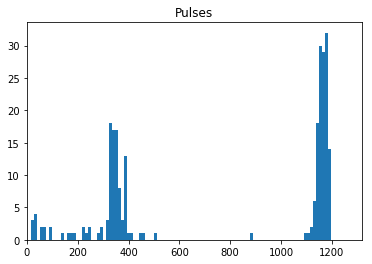

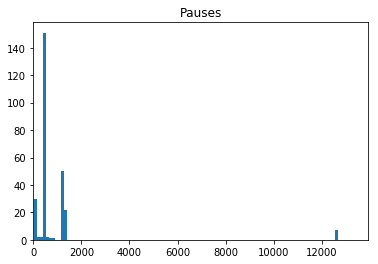

In [94]:
show_hist(data[data > 0], "Pulses", threshold=0.1)
show_hist(-data[data < 0], "Pauses", threshold=0.02) # обращаем внимание на непримечательный пик справа

Немножко удобной автоматики для группирования сигналов по длинам

In [99]:
# data - list of signals
# threshold - length of minimal distance between clusters
# threshold_count - minimal count of signals in group
# output format list of such structures 
# (letter, lower, upper, count) giving information about group
def clusterize_signals(data, threshold = 100, threshold_count = 10):
    groups = []

    for signals in (data[data > 0], data[data < 0]):
        # clasterization from scipy
        signals_color = hac.fclusterdata(X = np.matrix([signals]).T, 
                                  criterion='distance', t = threshold)
        for i in range(1, 10000):
            group = signals[signals_color == i]
            if (len(group) == 0):
                break
            bounds = (abs(int(group.mean())), group.min(), group.max(), len(group))
            if len(group) > threshold_count:
                groups.append(bounds)

    groups = sorted(groups)

    cur_impulse_code = ord('A')
    cur_pause_code = ord('a')

    for i in range(len(groups)):
        mean, lower, upper, count = groups[i]
        code = 0
        if (lower > 0):
            code = cur_impulse_code
            cur_impulse_code += 1
            groups[i] = (chr(code), 
                         max(1, int(lower - threshold / 3)), 
                         int(upper + threshold / 3), 
                         count)
        else:
            code = cur_pause_code
            cur_pause_code += 1
            groups[i] = (chr(code), 
                         int(lower - threshold / 3), 
                         min(int(upper + threshold / 3), -1), 
                         count)
    return groups

# делаем группы
groups = clusterize_signals(data, threshold = 200, threshold_count = 7)
print("(letter, lower, upper, count)")
print("\n".join(map(str, groups)))

(letter, lower, upper, count)
('A', 1, 575, 109)
('a', -618, -1, 187)
('B', 1034, 1308, 153)
('b', -1420, -1171, 72)
('c', -12729, -12547, 8)


Получили группы сигналов

In [100]:


# в общем случае стоит посмотреть глазами на группы сигналов и выделить нужные
groups = list(filter(lambda x: x[0] in {'A', 'B', 'a', 'b', 'c', 'd'}, groups))
groups

[('A', 1, 575, 109),
 ('a', -618, -1, 187),
 ('B', 1034, 1308, 153),
 ('b', -1420, -1171, 72),
 ('c', -12729, -12547, 8)]

In [101]:
# All the same but in a table
data_frame = pandas.DataFrame([(lower, upper, count) for letter, lower, upper, count in groups], 
                              index=[letter for letter, lower, upper, count in groups],
            
                              columns=['Lower length', 'Upper length', 'count of signals'])
data_frame.insert(1, "Type", ["impulse" if lower > 0 else "pause" for c, lower, upper, count in groups])
data_frame = data_frame.sort_index()
#data_frame = data_frame.pivot_table(index='Letter')
data_frame

,Lower length,Type,Upper length,count of signals
A,1,impulse,575,109
B,1034,impulse,1308,153
a,-618,pause,-1,187
b,-1420,pause,-1171,72
c,-12729,pause,-12547,8


Заменим каждый сигнал буквой, обозначающей его группу. Так зачастую удобнее

In [102]:
# finds signal in groups
# returns a corresponding letter
def decode_signal(x, groups):
    for c, lower, upper, group in groups:
        if lower <= x <= upper:
            return c
    return "?"

# decode list of signals
# each signal is decoded separately
def decode_signals(data, groups):
    return [decode_signal(signal, groups) for signal in data]


# decoded signals
data_letters = decode_signals(data, groups)

data_letters = [c if c != "d" else 'c' for c in data_letters]

print("Decoded (characters): ", "".join(data_letters))
    

Decoded (characters):  ?aBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbAcBaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbA?AaAaaaAaAaAaAaAaAa?a?cBaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbAcBaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbAcBaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaA?AaAaAaAaAa??BaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbAcBaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbAcBaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaA?A?AaAaAaAaAaAaAaa?Aa?a?cBaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbAcBaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbA?AaAaAaAaAa?a?a


Символ 'c' на порядок реже встречается и кажется разделителем. Поделим по нему.

In [103]:
print("\n".join(("".join(data_letters).split("c"))))
Counter("".join(data_letters).split("c"))

?aBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbA
BaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbA?AaAaaaAaAaAaAaAaAa?a?
BaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbA
BaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbA
BaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaA?AaAaAaAaAa??BaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbA
BaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbA
BaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaA?A?AaAaAaAaAaAaAaa?Aa?a?
BaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbA
BaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbA?AaAaAaAaAa?a?a


Counter({'?aBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbA': 1,
         'BaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaA?A?AaAaAaAaAaAaAaa?Aa?a?': 1,
         'BaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaA?AaAaAaAaAa??BaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbA': 1,
         'BaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbA': 4,
         'BaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbA?AaAaAaAaAa?a?a': 1,
         'BaBaBaBaBaBaBaBaBaBaAbAbBaAbBaBaAbBaBaAbAbBaAbAbA?AaAaaaAaAaAaAaAaAa?a?': 1})

Есть два пакета, повторившиеся много раз.

Дальше можно сделать еще несколько наблюдений, описанных в основной статье. А можно сразу делать все по даташиту.

Смотрим в даташит и видим, что `'Ac'` - импульс и длинная пауза - это преамбула. А `'Ab'` и `'Ba'` задают 0 и 1.

In [106]:
# заменим пары символов на их смысл
data_1 = "".join(data_letters).replace('c', 'P').replace('Ab', '0').replace('Ba', '1')
print(data_1[:300])

?a111111100101101100100AP111111111100101101100100A?AaAaaaAaAaAaAaAaAa?a?P111111111100101101100100AP111111111100101101100100AP111111111100101101A?AaAaAaAaAa??111111111100101101100100AP111111111100101101100100AP111111111100101101A?A?AaAaAaAaAaAaAaa?Aa?a?P111111111100101101100100AP111111111100101101100


Здесь уже хорошо видно периодичные 'P'-шки. Поделим всю строку на пакеты.

In [108]:
data = list(filter(lambda x: len(x) > 23, [x for y in data_1.split('?') for x in y.split('P') ]))
print(data)
Counter(data)

['111111111100101101100100A', '111111111100101101100100A', '111111111100101101100100A', '111111111100101101100100A', '111111111100101101100100A', '111111111100101101100100A', '111111111100101101100100A']


Counter({'111111111100101101100100A': 7})

Видим, что подряд идет помногу одинаковых пакетов. В снятых мною дампах это сигналы от датчика движения при двух разных конфигурациях джамперов

In [109]:
# именнованый кортеж, для более понятного вывода
from collections import namedtuple
Message = namedtuple('HSMessage', 'data channel')

# разделяем на непосредственно сообщение и флаги D0-D3
data_pairs = list(map(lambda x: Message(int(x[:20][::-1], 2), int(x[20:], 2)), data))
print(data_pairs)

# или в 16-ричной, если вам так больше нравится
data_pairs16 = list(map(lambda x: Message(hex(x[0]), hex(x[1])), data_pairs))
print(data_pairs16)


ValueError: invalid literal for int() with base 2: '0100A'

Готово!